In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv("../data/cleaned_heart_disease.csv")

In [20]:
print(df.shape)
df.head()

(920, 23)


,id,age,trestbps,chol,thalch,oldpeak,ca,num,sex_Male,dataset_Hungary,...,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,1,1.007386,0.705176,0.303643,0.489727,1.368109,-0.361400,-0.871794,1,0,...,0,1,1,0,0,0,0,0,0,0
1,2,1.432034,1.518569,0.789967,-1.181478,0.611589,4.411152,0.879408,1,0,...,0,0,0,0,0,1,1,0,1,0
2,3,1.432034,-0.650479,0.266939,-0.345875,1.651804,2.820301,0.003807,1,0,...,0,0,0,0,0,1,1,0,0,1
3,4,-1.752828,-0.108217,0.459634,1.961979,2.502889,-0.361400,-0.871794,1,0,...,1,0,0,1,0,0,0,0,1,0
4,5,-1.328180,-0.108217,0.037541,1.365120,0.517024,-0.361400,-0.871794,0,0,...,0,0,0,0,0,0,0,1,1,0


In [24]:
# Fix scaled target by thresholding
df['num'] = (df['num'] > 0).astype(int)

print(df['num'].value_counts())

num
1    509
0    411
Name: count, dtype: int64


In [26]:
X = df.drop(columns=["id","num"])
y = df["num"]

In [27]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X,y)

RandomForestClassifier(random_state=42)

In [33]:
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Features': X.columns,
    'Importance': importances,
}).sort_values(by='Importance', ascending=False)

In [34]:
print("Top 10 Important Features:")
print(feature_importance_df.head(10))

Top 10 Important Features:
               Features  Importance
2                  chol    0.132250
3                thalch    0.122939
4               oldpeak    0.119713
0                   age    0.094582
16           exang_True    0.079711
1              trestbps    0.071299
10   cp_atypical angina    0.068818
6              sex_Male    0.043620
8   dataset_Switzerland    0.034378
11       cp_non-anginal    0.033995


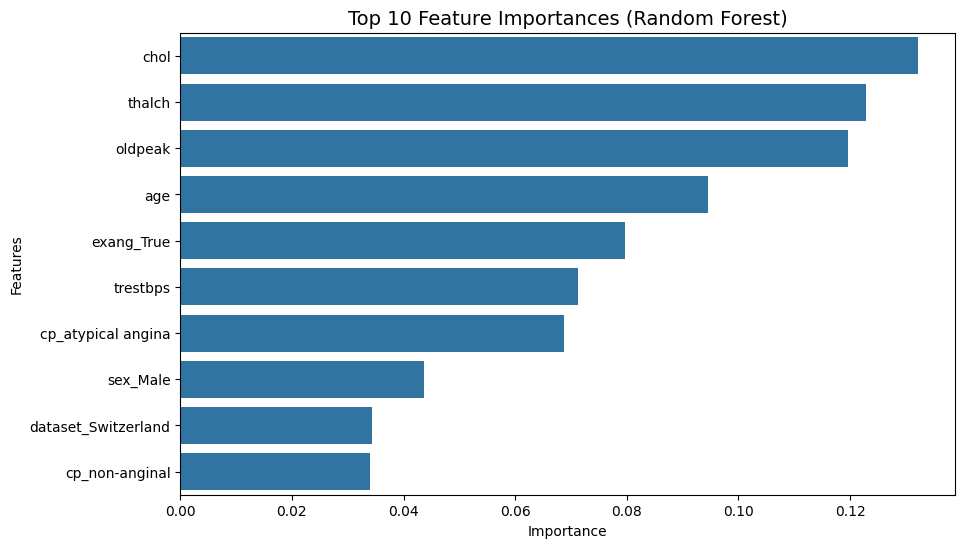

In [41]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance', 
    y='Features',  
    data=feature_importance_df.head(10),
)
plt.title('Top 10 Feature Importances (Random Forest)', fontsize=14)
plt.show()


In [44]:
model = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X,y)

selected_features = X.columns[rfe.support_]
print("\nSelected Features by RFE:")
print(selected_features)


Selected Features by RFE:
Index(['oldpeak', 'sex_Male', 'dataset_Switzerland', 'dataset_VA Long Beach',
       'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina',
       'exang_True', 'slope_flat', 'thal_normal'],
      dtype='object')


In [48]:
X_chi2 = MinMaxScaler().fit_transform(X)

chi2_selector = SelectKBest(chi2, k=10)
chi2_selector.fit(X_chi2, y)

chi2_features = X.columns[chi2_selector.get_support()]

print("\nTop 10 Features by Chi-Square Test:")
print(chi2_features)


Top 10 Features by Chi-Square Test:
Index(['sex_Male', 'dataset_Hungary', 'dataset_Switzerland',
       'dataset_VA Long Beach', 'cp_atypical angina', 'cp_non-anginal',
       'exang_True', 'slope_upsloping', 'thal_normal',
       'thal_reversable defect'],
      dtype='object')


In [51]:
selected_set = set(selected_features) | set(chi2_features) | set(feature_importance_df.head(10)['Features'])

print("Final Selected Key Features (Union of All Methods):")
print(selected_set)

Final Selected Key Features (Union of All Methods):
{'trestbps', 'dataset_Hungary', 'slope_flat', 'sex_Male', 'thal_reversable defect', 'dataset_Switzerland', 'age', 'slope_upsloping', 'cp_non-anginal', 'chol', 'oldpeak', 'thalch', 'dataset_VA Long Beach', 'exang_True', 'cp_atypical angina', 'cp_typical angina', 'thal_normal'}


In [52]:
df_selected = df[list(selected_set) + ["num"]]

print("\n reduced dataset", df_selected.shape)
df_selected.head()


 reduced dataset (920, 18)


,trestbps,dataset_Hungary,slope_flat,sex_Male,thal_reversable defect,dataset_Switzerland,age,slope_upsloping,cp_non-anginal,chol,oldpeak,thalch,dataset_VA Long Beach,exang_True,cp_atypical angina,cp_typical angina,thal_normal,num
0,0.705176,0,0,1,0,0,1.007386,0,0,0.303643,1.368109,0.489727,0,0,0,1,0,0
1,1.518569,0,1,1,0,0,1.432034,0,0,0.789967,0.611589,-1.181478,0,1,0,0,1,1
2,-0.650479,0,1,1,1,0,1.432034,0,0,0.266939,1.651804,-0.345875,0,1,0,0,0,1
3,-0.108217,0,0,1,0,0,-1.752828,0,1,0.459634,2.502889,1.961979,0,0,0,0,1,0
4,-0.108217,0,0,0,0,0,-1.328180,1,0,0.037541,0.517024,1.365120,0,0,1,0,1,0


C:\Users\user\AppData\Local\Temp\ipykernel_5160\2230758220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


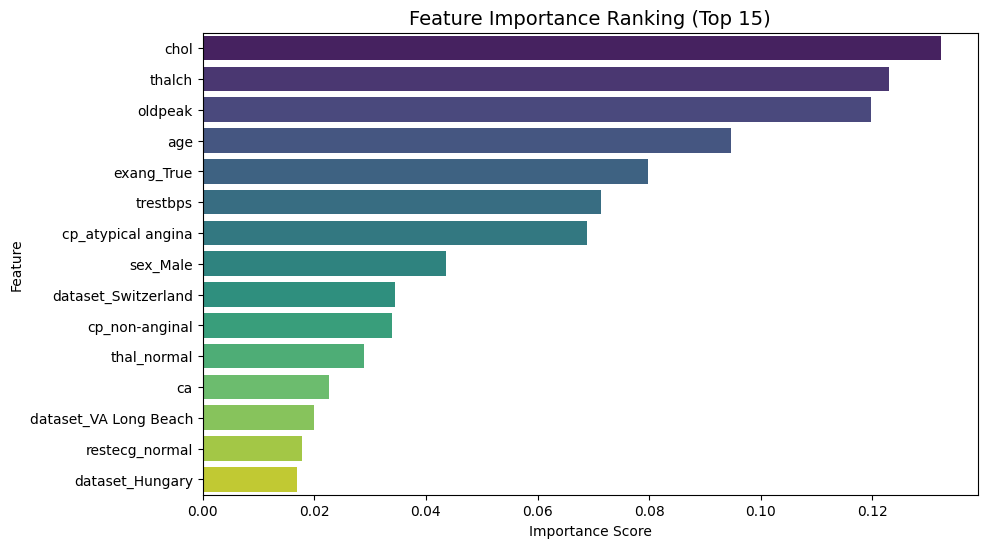

In [54]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance', 
    y='Features', 
    data=feature_importance_df.head(15), 
    palette='viridis'
)
plt.title('Feature Importance Ranking (Top 15)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()
